<a href="https://colab.research.google.com/github/dylan33smith/HistopathologicCancerDetection/blob/main/KaggleDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dylan Smith
## CSPB 3202: Fall 2023
## Homework 5: Kaggle Competition

In [8]:
from google.colab import files


In [9]:
uploaded = files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [10]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.29G/6.31G [01:15<00:00, 140MB/s]
100% 6.31G/6.31G [01:15<00:00, 89.7MB/s]


In [11]:
import zipfile

In [12]:
with zipfile.ZipFile('/content/histopathologic-cancer-detection.zip','r') as zip_ref:
  zip_ref.extractall('content/histopathologic_dataset')

(1m 43s) to complete

In [ ]:
!pip install h5py

In [ ]:
!pip install pandas
!pip install numpy==1.24.3
!pip install scikit-learn

In [ ]:
!pip install tensorflow


# Histopathic Cancer Detection

Create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans



In [1]:
import os
import random
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.optimizers import Adam

import h5py

In [2]:
train_df = pd.read_csv('./content/histopathologic_dataset/train_labels.csv')
# This is a df of the image id and it's associated pos/neg label (for training images)
train_df.head()
# shape: (220025, 2)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [3]:
# get training images
train_dir = './content/histopathologic_dataset/train/'


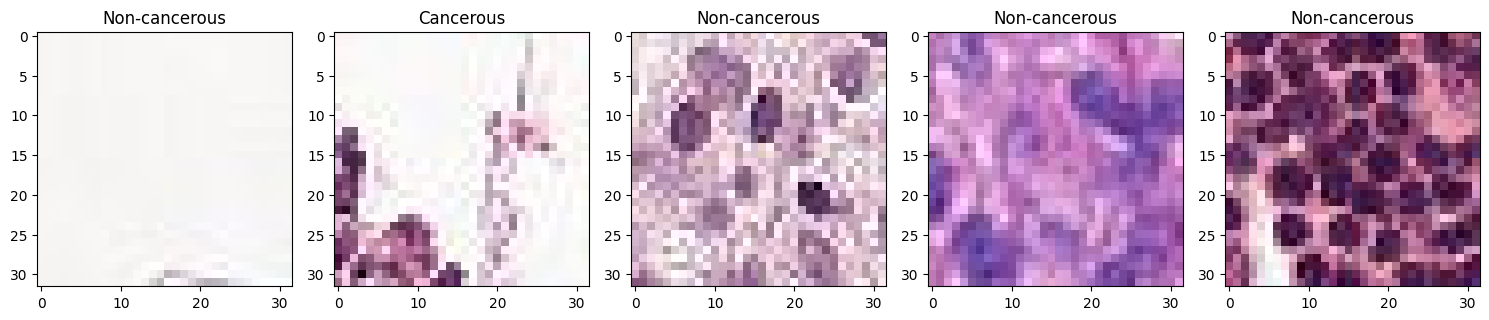

In [4]:
train_head = train_df.head(5)

plt.figure(figsize=(15, 3))
for i, row in enumerate(train_head.iterrows()):
    img_id, label = row[1]
    img_path = train_dir + f'{img_id}.tif'
    img = Image.open(img_path)
    # crop center 32x32
    img = img.crop((32, 32, 64, 64))

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    if label == 0:
      plt.title("Non-cancerous")
    else:
      plt.title("Cancerous")

plt.tight_layout()
plt.show()

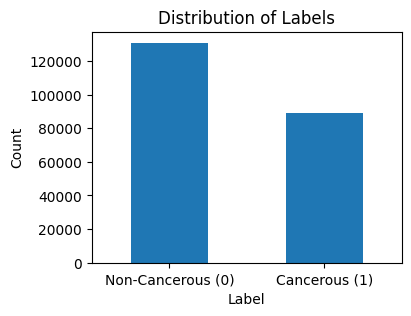

In [5]:
label_count = train_df['label'].value_counts()

plt.figure(figsize=(4, 3))
label_count.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Cancerous (0)', 'Cancerous (1)'], rotation=0)
plt.show()

From the above plot, we can see that there are only values of 0 and 1 (no NULL) for labels in the data. We will assume that the data is clean clean and can be used as is.

In [6]:
c_perc = (label_count[0] / (label_count[0] + label_count[1]))
nc_perc = (label_count[1] / (label_count[0] + label_count[1]))
ratio = label_count[0] / label_count[1]

print(f"non-cancerous: {label_count[0]}, {c_perc*100:9.2f}%")
print(f"cancerous: {label_count[1]},  {nc_perc*100:9.2f}%")
print(f"Class Imbalance: {ratio:9.2f}")

non-cancerous: 130908,     59.50%
cancerous: 89117,      40.50%
Class Imbalance:      1.47


From the above plot and ratio, we can see that there is a substantial imbalance between cancerous and non-cancerous images, with almost 1.5 times as many non-cancerous samples as cancerous. In order to address this, we will undersample to non-cancerous images so there are equal amounts of each. This will still leave a substantial amount of data so the tradeoff between data-loss and skew is reasonable.

In [7]:
# seperate into cancerous and non-cancerous
train_cancer = train_df[train_df['label'] == 1]
train_non_cancer = train_df[train_df['label'] == 0]

# randomly sample non-cancerous samples to match number of cancerous
train_non_cancer_under = train_non_cancer.sample(n=len(train_cancer['label']), random_state = 33)

# sanity check
print(train_non_cancer_under.shape)
print(train_cancer.shape)

(89117, 2)
(89117, 2)


In [8]:
# combine cancerous with undersampled non-cancerous
train_dataset = pd.concat([train_cancer, train_non_cancer_under])

# save new training dataset
# train_dataset.to_csv('./content/histopathologic_dataset/balanced_train_data.csv', index=False)

# sanity check
print(f"Total number of samples: {len(train_dataset)}")
print(train_dataset['label'].value_counts())

Total number of samples: 178234
1    89117
0    89117
Name: label, dtype: int64


## Image Processing Section
Convert images to np array containing numerical representations of all images. This array can then be used as input data (features) for ML models.

In [9]:
###### don't run!! takes a long time ############
# check all images are same size
  # removes calculations in get_images cropping of center pixels
  # only tissue in center 32x32 patch influences label
# for path in train_img_paths:
  # img = Image.open(path)
  # if img.size != (96, 96):
    # print("not all same size")
    # break

In [10]:
def save_images_to_hdf5(img_ids, hdf5_path, dataset_name):
    '''
    Save image data from all of the images in training folder to an HDF5 file.
    Resize to only include center 32x32 pixels (from 96x96 of original).
    Scale pixel values to range between 0 and 1.

    Parameters:
    img_ids: List of image IDs.
    hdf5_path: Path to save the HDF5 file.
    dataset_name: Name of the dataset in the HDF5 file.
    '''

    # Calculate the number of images
    num_images = len(img_ids)

    # Create a new HDF5 file
    with h5py.File(hdf5_path, "w") as hf:
        # Create a dataset in the file to hold all the images
        # dataset = hdf5_file.create_dataset(
            # "images", (num_images, 32, 32, 3), np.float32
        # )
        dataset = hf.create_dataset(f'{dataset_name}', (num_images, 32, 32, 3), np.float32)

        for i, img_id in enumerate(img_ids):
            img_path = os.path.join(train_dir, img_id + '.tif')
            img = Image.open(img_path)

            # Crop center 32 pixels
            img = img.crop((32, 32, 64, 64))  # left, upper, right, lower pixel coordinates

            # normalize
            img_arr = np.array(img) / 255.0

            # store the image in the dataset
            dataset[i, ...] = img_arr



In [11]:
def load_images_from_hdf5(hdf5_path, dataset_name, indices):
    '''
    Load images from an HDF5 file based on indice.

    Parameters:
    hdf5_path: Path to the hdf5 file.
    dataset_name: Name of the dataset in the hdf5 file.
    indices: list of indices to extract from hdf5

    '''
    with h5py.File(hdf5_path, "r") as hf:
        images = np.empty((len(indices), 32, 32, 3))
        for i, idx in enumerate(indices):
            images[i] = hf[dataset_name][idx]

    return images

In [12]:
# get the path to each of the images in the balanced dataset
train_ids = train_dataset['id'].values

In [35]:
# only have to run once to save hdf5 file
# save_images_to_hdf5(train_ids, './content/training_images.h5', 'processed_images')
# 4m 12s

To get images, use
- load_images_from_hdf5('./content/training_images.h5', 'processed_images', indices)

 This will be used to get the training and testing images by their indice after train_test_split has been used. Avoids having to load the whole dataset into memory on top of the training and testing datasets.

# Model architecture

The architecture for my model will be relatively simple, with a small number of layers, relu activation and a final sigmoidal layer for binary classification.

**Convolutional Layers** <br>
Convolutional layers use kernals (filters) to slide over the input image in order to extract and learn simple features within the image including vertical edges, horizontal edges, textures, etc.  


In [13]:
# get just the pos/neg labels from train_df
train_labels = train_dataset['label'].values

In [14]:
# sanity check
print(train_labels.shape)
print(type(train_labels))

(178234,)
<class 'numpy.ndarray'>


In [15]:
# seperate data into training and validation
training_indices, testing_indices, training_labels, testing_labels = train_test_split(
    range(len(train_labels)),
    train_labels,
    test_size = 0.2,
    random_state = 33
)

In [16]:
training_images = load_images_from_hdf5('./content/training_images.h5', 'processed_images', training_indices)
testing_images = load_images_from_hdf5('./content/training_images.h5', 'processed_images', testing_indices)

# (54s)
# 4 GB RAM
# garbage collect these after model is trained on them to save up RAM

In [17]:
# sanity check
print(training_images.shape)
print(testing_images.shape)
print(training_labels.shape)
print(testing_labels.shape)

(142587, 32, 32, 3)
(35647, 32, 32, 3)
(142587,)
(35647,)


## Model





In [18]:

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 64)                1

In [19]:
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
history = model.fit(training_images, training_labels, epochs=10,
                    validation_data=(testing_images, testing_labels))

Epoch 1/10
4456/4456 [==============================] - 117s 26ms/step - loss: 0.5079 - accuracy: 0.7584 - val_loss: 0.4816 - val_accuracy: 0.7787
Epoch 2/10
4456/4456 [==============================] - 110s 25ms/step - loss: 0.4682 - accuracy: 0.7839 - val_loss: 0.4519 - val_accuracy: 0.7929
Epoch 3/10
4456/4456 [==============================] - 113s 25ms/step - loss: 0.4515 - accuracy: 0.7936 - val_loss: 0.4767 - val_accuracy: 0.7811
Epoch 4/10
4456/4456 [==============================] - 112s 25ms/step - loss: 0.4400 - accuracy: 0.8007 - val_loss: 0.4379 - val_accuracy: 0.8002
Epoch 5/10
4456/4456 [==============================] - 110s 25ms/step - loss: 0.4294 - accuracy: 0.8060 - val_loss: 0.4657 - val_accuracy: 0.7824
Epoch 6/10
4456/4456 [==============================] - 117s 26ms/step - loss: 0.4212 - accuracy: 0.8090 - val_loss: 0.4289 - val_accuracy: 0.8065
Epoch 7/10
4456/4456 [==============================] - 114s 26ms/step - loss: 0.4150 - accuracy: 0.8131 - val_loss: 0

(18m 2s)

## Model Results

In [21]:
# Extracting loss, training accuracy, and validation accuracy from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

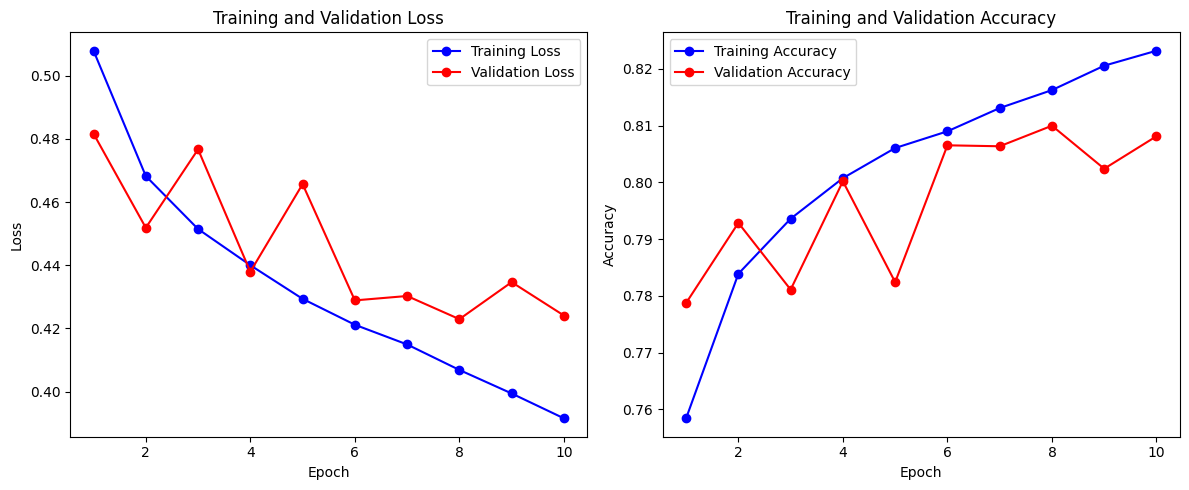

In [22]:
# Plot loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
# Training complete. clean up space in RAM
import gc

del training_images
del testing_images

gc.collect()

11803

In [29]:
del train_cancer
del train_dataset
del train_df
del train_dir
del train_head
del train_ids
del train_labels
del train_non_cancer
del train_non_cancer_under
del train_test_split

gc.collect()

768

In [27]:
def save_test_images_to_hdf5(test_dir, hdf5_path, dataset_name):
    '''
    Save image data from all of the images in training folder to an HDF5 file.
    Resize to only include center 32x32 pixels (from 96x96 of original).
    Scale pixel values to range between 0 and 1.

    Parameters:
    img_paths: List of image IDs.
    hdf5_path: Path to save the HDF5 file.
    dataset_name: Name of the dataset in the HDF5 file.
    '''

    with h5py.File(hdf5_path, 'w') as hf:
      # get images from test directory
      img_files = [image for image in os.listdir(test_dir) if image.endswith('.tif')]

      dataset = hf.create_dataset(f'{dataset_name}', (len(img_files), 32, 32, 3), np.float32)

      for i, file in enumerate(img_files):
        img_path = os.path.join(test_dir, file)
        img = Image.open(img_path)

      # crop center 32x32 pixels
      img = img.crop((32, 32, 64, 64))

      # normalize
      img_arr = np.array(img) / 255.0

      # store image in dataset
      dataset[i, ...] = img_arr

In [38]:
def load_test_images_from_hdf5(hdf5_path, dataset_name):
    '''
    Load images from an HDF5 file based on indice.

    Parameters:
    hdf5_path: Path to the hdf5 file.
    dataset_name: Name of the dataset in the hdf5 file.
    indices: list of indices to extract from hdf5

    '''
    with h5py.File(hdf5_path, "r") as hf:

        images = hf[dataset_name][:]

    return images

In [28]:
test_dir = './content/histopathologic_dataset/test'

# save hdf5 file --> only need to run once
# save_images_to_hdf5(train_ids, './content/training_images.h5', 'processed_images')
# save_test_images_to_hdf5(test_dir, './content/testing_images.h5', 'processed_images')
# (1m 2s)

In [39]:
test_images = load_test_images_from_hdf5('./content/testing_images.h5', 'processed_images')

In [40]:
test_images.shape

(57458, 32, 32, 3)

## Label Prediction using Model

In [43]:
predictions = model.predict(test_images)

1796/1796 [==============================] - 16s 9ms/step


In [48]:
# convert the prediction to binary 0 or 1 to map to non-cancerous or cancerous respectively
tf_predictions = (predictions > 0.5).astype(int).flatten()

In [50]:
# extract image IDs
test_img_ids = [os.path.splitext(file)[0] for file in os.listdir(test_dir) if file.endswith('.tif')]

In [52]:
# sanity check
len(test_img_ids)

57458

In [53]:
# put test predictions into correct format (id, label)
final = pd.DataFrame({
    'id': test_img_ids,
    'label': tf_predictions
})

In [54]:
# save final results to .csv
final.to_csv('/content/model_results.csv', index=False)

In [55]:
!pwd

/content
